# Download Data

Download the BTC-USD Dataset from Perplexity Finance.

Save the file into the directory ./data/raw/

# Initialization

In [1]:
%load_ext dotenv
%dotenv 

In [2]:
#%pip install mplfinance
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import sys
from glob import glob


from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
#import mplfinance as mpf
import seaborn as sns
import yfinance as yf


# Add the src directory to the path
src_dir = os.getenv('SRC_DIR')
if src_dir is None:
	# Fallback: assume notebooks folder is one level below project root
	project_root = os.path.dirname(os.getcwd())
	src_dir = os.path.join(project_root, 'src')
print(f"Adding to path: {src_dir}")
sys.path.append(src_dir)

from utils.logger import get_logger
_logs = get_logger(__name__)

Adding to path: ../src/


## Importing Dataset

In [4]:
import hashlib

# Load data
# Define ordered column names to enforce consistent schema (overrides original file header)
columns = [
    'Date', 
    'Close',          
    'Open', 
    'High',                
    'Low', 
    'Volume'
]

btc_file = os.getenv("BTC_DATA")

# Read the raw CSV:
# - header=0 reads the first line (original names) but they are replaced by 'columns'
# - names=columns ensures consistent snake_case naming initialize above
btc_dt = (pd.read_csv(btc_file, header = 0, names = columns))

# Save processed data to a new CSV folder and appeand file name with hash value
    
# Create a hash of the DataFrame
df_hash = hashlib.md5(btc_dt.to_csv(index=False).encode()).hexdigest()
processed_btc_file = os.getenv("PROCESSED_BTC_DATA").replace(".csv", f"_{df_hash}.csv")
btc_dt.to_csv(processed_btc_file, index=False)

# Log the completion of data loading and feature creation and record file name
_logs.info("Loaded BTC-USD dataset into DataFrame.")
_logs.info(f"Processed BTC-USD dataset saved to: {processed_btc_file}")

2025-11-09 13:10:39,004, 2713969401.py, 29, INFO, Loaded BTC-USD dataset into DataFrame.
2025-11-09 13:10:39,005, 2713969401.py, 30, INFO, Processed BTC-USD dataset saved to: ../data/processed/btc_processed_8d4c513d70341c9eb8c09d7c4aa06be1.csv


# Sentiment data

In [ ]:
#! pip install vaderSentiment

In [19]:
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm

In [ ]:
#raw_sentiment_file = os.getenv("SENTIMENT_DATA") #if not working use instead: SENTIMENT_DATA=../data/raw/Bitcoin_tweets.csv
#sentiment_dt = pd.read_csv(raw_sentiment_file)
#sentiment_dt.head()

In [ ]:
import pandas as pd
import re

# Sort by date
#df_raw = sentiment_dt.sort_values(by='date')

# Sample 1% (non-repeating, reproducible)
#dd = df_raw.sample(frac=0.01, replace=False, random_state=1).reset_index(drop=True)

# Clean text using vectorized regex replacements
#dd['text'] = (
#    dd['text']
#    .astype(str)
#    .str.replace('#', '', regex=False)  # Remove hashtags
#    .str.replace(r'https?://\S+', '', regex=True)  # Remove URLs
#    .str.replace(r'@\w+', '', regex=True)  # Remove mentions
#    .str.strip()  # Remove leading/trailing spaces
#    .str.lower() # Convert to lowercase
#)

# Save cleaned tweets
#tweets_clean_file = "bitcoin_tweets_clean.csv"
#dd.to_csv(tweets_clean_file, header=True, encoding='utf-8', index=False)


In [ ]:
tweets_clean_file = "bitcoin_tweets_clean.csv" #assuming is in the same dir as this notebook!
df_clean = pd.read_csv(tweets_clean_file)
df_clean.info()
df_clean.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957625 entries, 0 to 957624
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         957624 non-null  object 
 1   user_location     104706 non-null  object 
 2   user_description  122744 non-null  object 
 3   user_created      127933 non-null  object 
 4   user_followers    127926 non-null  float64
 5   user_friends      127926 non-null  object 
 6   user_favourites   127926 non-null  object 
 7   user_verified     127926 non-null  object 
 8   date              46880 non-null   object 
 9   text              46880 non-null   object 
 10  hashtags          46674 non-null   object 
 11  source            46834 non-null   object 
 12  is_retweet        46863 non-null   object 
dtypes: float64(1), object(12)
memory usage: 95.0+ MB


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
957620,$BONK 0.55%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
957621,"#bitcoin #crypto #cryptonews #cryptocurrencies""",2022-08-03 13:08:37,930,5,4.0,False,2023-01-09 12:57:01,$ECOX price go up 0.86% in last minute on #Bybit,NaN,NaN,NaN,NaN,NaN
957622,$NCT 0.45%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
957623,$CEEK 0.5%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
957624,$JFI 1.07%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# understanding how many twits have data vs. 957624
len(df_clean['date']) - df_clean['date'].isna().sum()

46880

In [32]:
# Convert 'date' column to pandas datetime format
df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month
df_clean['day'] = df_clean['date'].dt.day
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957625 entries, 0 to 957624
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_name         957624 non-null  object        
 1   user_location     104706 non-null  object        
 2   user_description  122744 non-null  object        
 3   user_created      127933 non-null  object        
 4   user_followers    127926 non-null  float64       
 5   user_friends      127926 non-null  object        
 6   user_favourites   127926 non-null  object        
 7   user_verified     127926 non-null  object        
 8   date              46879 non-null   datetime64[ns]
 9   text              46880 non-null   object        
 10  hashtags          46674 non-null   object        
 11  source            46834 non-null   object        
 12  is_retweet        46863 non-null   object        
 13  year              46879 non-null   float64       
 14  mont

In [33]:
# Get the min and max dates
start_date = df_clean['date'].min()
end_date = df_clean['date'].max()

print(f" Your cleaned tweets range from {start_date.date()} to {end_date.date()}")


 Your cleaned tweets range from 2021-02-05 to 2023-01-09


In [34]:
#drop NAs
df_condensed = df_clean.dropna(subset=['text'])
df_condensed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46880 entries, 8 to 957607
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_name         46879 non-null  object        
 1   user_location     23653 non-null  object        
 2   user_description  41691 non-null  object        
 3   user_created      46880 non-null  object        
 4   user_followers    46880 non-null  float64       
 5   user_friends      46880 non-null  object        
 6   user_favourites   46880 non-null  object        
 7   user_verified     46880 non-null  object        
 8   date              46879 non-null  datetime64[ns]
 9   text              46880 non-null  object        
 10  hashtags          46674 non-null  object        
 11  source            46834 non-null  object        
 12  is_retweet        46863 non-null  object        
 13  year              46879 non-null  float64       
 14  month             46879 no

In [35]:
# implement sentiment analysis, taking compound feature
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(df_condensed['text'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_condensed["compound"] = compound
df_condensed.head(2)

100%|██████████| 46880/46880 [00:03<00:00, 14905.91it/s]
/var/folders/kb/wzn_7bf509s7f6q3b7yjdcnh0000gn/T/ipykernel_65499/1636950145.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condensed["compound"] = compound


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,year,month,day,compound
8,Anıl,NaN,Anıl cngz,2021-11-16 17:00:30,261.0,1025.0,8962.0,False,2022-04-15 20:15:06,our target is 1 billion market value by the en...,['Bitcoin'],Twitter for Android,False,2022.0,4.0,15.0,0.6486
12,The Daydream Brand,USA,I manufacture physical items and sell them onl...,2022-03-10 06:55:34,10.0,105.0,95.0,False,2022-04-15 15:13:04,bitcoin is exactly what we need,['Bitcoin'],Twitter Web App,False,2022.0,4.0,15.0,0.0000


In [43]:
# ADDING OTHER TWITTER VARAIBLES TO WEIGHT SENTIMENT
# convert columns to numeric; invalid parsing becomes NaN
df = df_condensed.copy()
df['compound'] = pd.to_numeric(df['compound'], errors='coerce')
df['user_followers'] = pd.to_numeric(df['user_followers'], errors='coerce')
df['user_favourites'] = pd.to_numeric(df['user_favourites'], errors='coerce')
df['is_retweet'] = pd.to_numeric(df['is_retweet'], errors='coerce')

# compute ratio safely using +1 smoothing (vectorized)
ratio = (df['user_favourites'] + 1) / (df['user_followers'] + 1)

# compute score (results will be NaN if compound is NaN)
df['score'] = df['compound'] * df['user_followers'] * ratio * (df['is_retweet'] + 1)

# NaN for rows that had original NaNs in key inputs:
mask_valid = df[['compound','user_followers','user_favourites','is_retweet']].notnull().all(axis=1)
df.loc[~mask_valid, 'score'] = np.nan

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 46880 entries, 8 to 957607
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_name         46879 non-null  object        
 1   user_location     23653 non-null  object        
 2   user_description  41691 non-null  object        
 3   user_created      46880 non-null  object        
 4   user_followers    46880 non-null  float64       
 5   user_friends      46880 non-null  object        
 6   user_favourites   46879 non-null  float64       
 7   user_verified     46880 non-null  object        
 8   date              46879 non-null  datetime64[ns]
 9   text              46880 non-null  object        
 10  hashtags          46674 non-null  object        
 11  source            46834 non-null  object        
 12  is_retweet        46863 non-null  float64       
 13  year              46879 non-null  float64       
 14  month             46879 no

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,year,month,day,compound,score
8,Anıl,NaN,Anıl cngz,2021-11-16 17:00:30,261.0,1025.0,8962.0,False,2022-04-15 20:15:06,our target is 1 billion market value by the en...,['Bitcoin'],Twitter for Android,0.0,2022.0,4.0,15.0,0.6486,5791.213244
12,The Daydream Brand,USA,I manufacture physical items and sell them onl...,2022-03-10 06:55:34,10.0,105.0,95.0,False,2022-04-15 15:13:04,bitcoin is exactly what we need,['Bitcoin'],Twitter Web App,0.0,2022.0,4.0,15.0,0.0000,0.000000
22,blockbytes,NaN,latest #crypto & #blockchain news,2020-12-25 11:16:23,38.0,7.0,4.0,False,2021-08-16 16:15:30,how to start your career in artificial intelli...,"['crypto', 'blockchain', 'bitcoin', 'eth', 'xrp']",newsy.co,0.0,2021.0,8.0,16.0,0.5255,2.560128
60,Epic Curious #GetOnZero,$0.00 #GetOnZero ask me how,"Praise the Lord, who is my rock. He trains my ...",2021-06-03 23:27:37,417.0,584,11961.0,False,2022-11-15 16:14:15,"if people cared about your message, you wouldn...",['Bitcoin'],Twitter for iPhone,0.0,2022.0,11.0,15.0,0.3400,4057.350144
83,LuxuriousVerseNFT,Metaverse,Luxury Item For Luxury People's,2022-03-07 01:56:49,293.0,727,2423.0,False,2022-03-19 10:19:37,🔥luxury gold lotus 1\n\nmust\n1️⃣follow \n\n\n...,"['ETH', 'NFT', 'NFTCollection', 'NFTCommunity'...",Twitter Web App,0.0,2022.0,3.0,19.0,0.0000,0.000000


In [ ]:
## AGG SCORES BY DAY TO JOIN WITH BITCOIN DATA

df_to_aggregated = df[['year','month','day','score']]
df_aggregated = (
    df_to_aggregated
    .groupby(['year', 'month', 'day'])
    .agg(
        total_score=('score', 'sum'),
    )
    .reset_index()
)

In [ ]:
# Combine year, month, and day into a single datetime column
df_aggregated["date"] = pd.to_datetime(df_aggregated[["year", "month", "day"]])

# Sort by date (important for line plots)
df_aggregated = df_aggregated.sort_values("date")

In [48]:
df_aggregated.info()
df_aggregated.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   year         222 non-null    float64       
 1   month        222 non-null    float64       
 2   day          222 non-null    float64       
 3   total_score  222 non-null    float64       
 4   date         222 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 8.8 KB


,year,month,day,total_score,date
0,2021.0,2.0,5.0,16945.578593,2021-02-05
1,2021.0,2.0,6.0,-3404.407857,2021-02-06
2,2021.0,2.0,7.0,74209.646402,2021-02-07
3,2021.0,2.0,8.0,14259.095988,2021-02-08
4,2021.0,2.0,9.0,205653.959390,2021-02-09


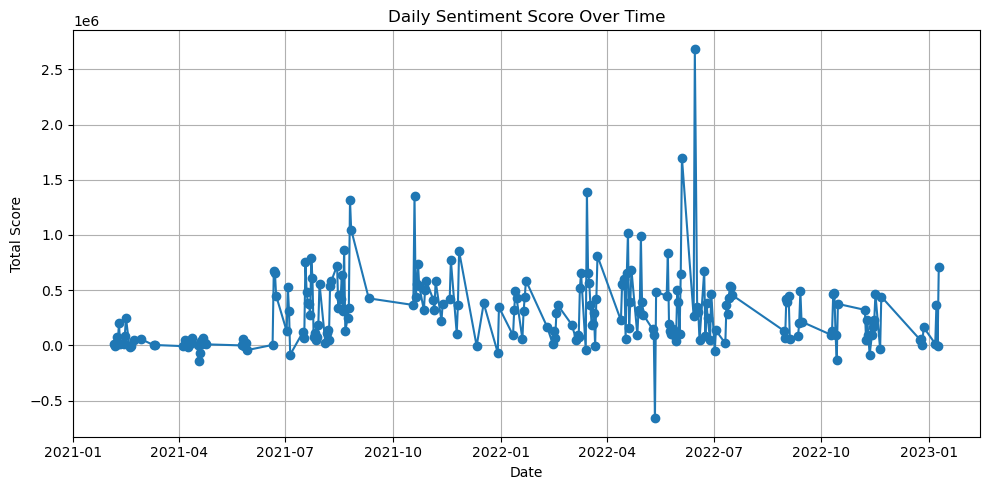

In [ ]:
import matplotlib.pyplot as plt

# Plot: Score (Y) vs Date (X)
plt.figure(figsize=(10,5))
plt.plot(df_aggregated["date"], df_aggregated["total_score"], marker='o')

# Add titles and labels
plt.title("Daily Sentiment Score Over Time")
plt.xlabel("Date")
plt.ylabel("Total Score")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


# Exploratory Data Analysis

In [50]:
# Observe the data structure
btc_dt.info()

# Print the shape of the DataFrame
print(f"BTC-USD DataFrame shape: {btc_dt.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1827 non-null   object 
 1   Close   1827 non-null   float64
 2   Open    1827 non-null   float64
 3   High    1827 non-null   float64
 4   Low     1827 non-null   float64
 5   Volume  1827 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 85.8+ KB
BTC-USD DataFrame shape: (1827, 6)


In [51]:
# Check for missing values
btc_dt.isnull().sum()

Date      0
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64

In [52]:
# Display the first few rows
print("First few rows of BTC-USD DataFrame:")
btc_dt.head()


First few rows of BTC-USD DataFrame:


,Date,Close,Open,High,Low,Volume
0,2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439
1,2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971
2,2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706
3,2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029
4,2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566


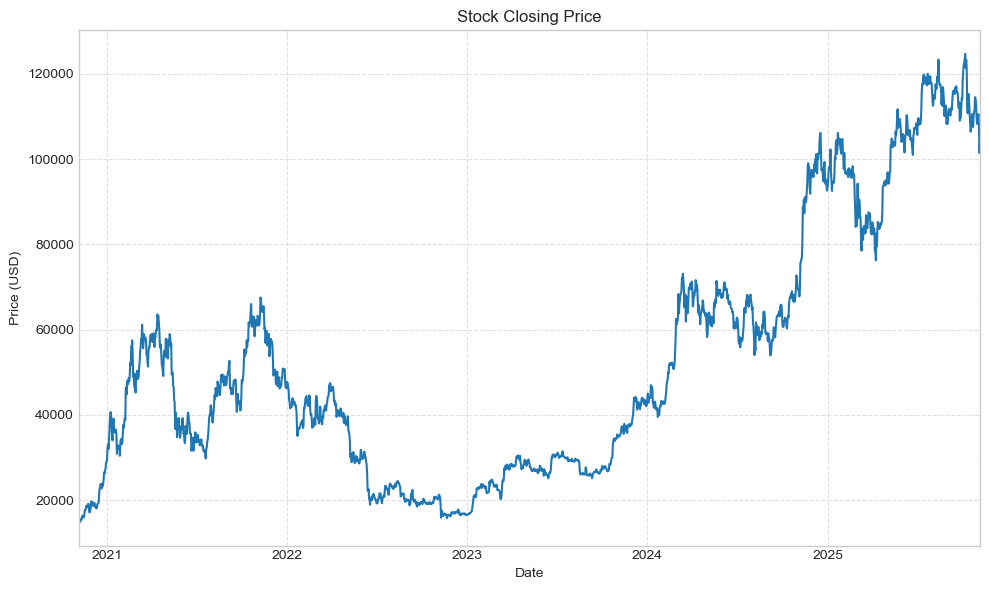

In [53]:
# Style sheet
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


# Ensure Date is datetime
btc_dt['Date'] = pd.to_datetime(btc_dt['Date'])
# Set date as index
btc_dt = btc_dt.set_index('Date')


btc_dt['Close'].plot(figsize=(10, 6), title='Stock Closing Price')

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

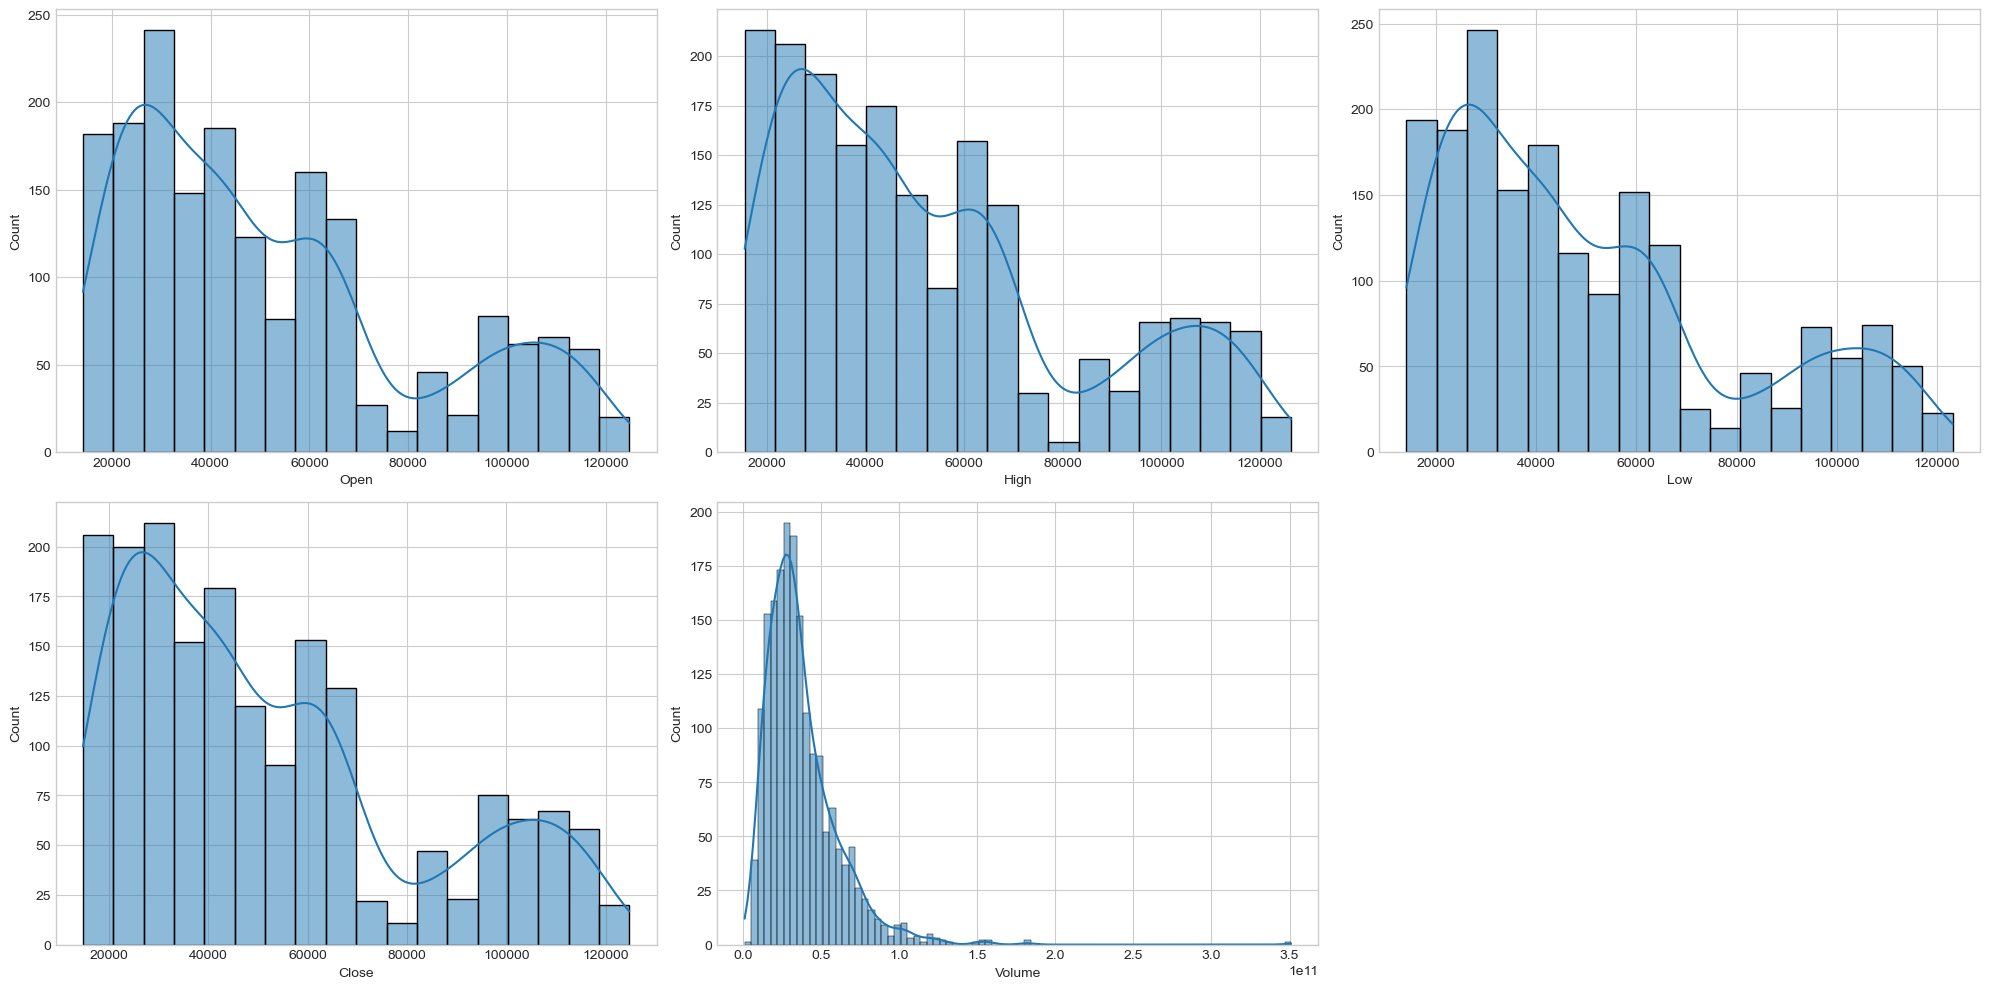

In [54]:
# Distribution Plots
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(20,10))

for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    sb.histplot(btc_dt[col], kde=True)  # replaces distplot

plt.tight_layout()
plt.show()

# Feature Engineering

In [55]:
# Extract year, month, day from the DatetimeIndex
btc_dt['Year'] = btc_dt.index.year
btc_dt['Month'] = btc_dt.index.month
btc_dt['Day'] = btc_dt.index.day

btc_dt.head()

,Close,Open,High,Low,Volume,Year,Month,Day
Date,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,2020,11,5
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,2020,11,6
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,2020,11,7
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,2020,11,8
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,2020,11,9


In [56]:
import numpy as np

btc_dt['is_quarter_end'] = np.where(btc_dt['Month']%3==0,1,0)
btc_dt.head()

,Close,Open,High,Low,Volume,Year,Month,Day,is_quarter_end
Date,,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,2020,11,5,0
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,2020,11,6,0
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,2020,11,7,0
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,2020,11,8,0
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,2020,11,9,0


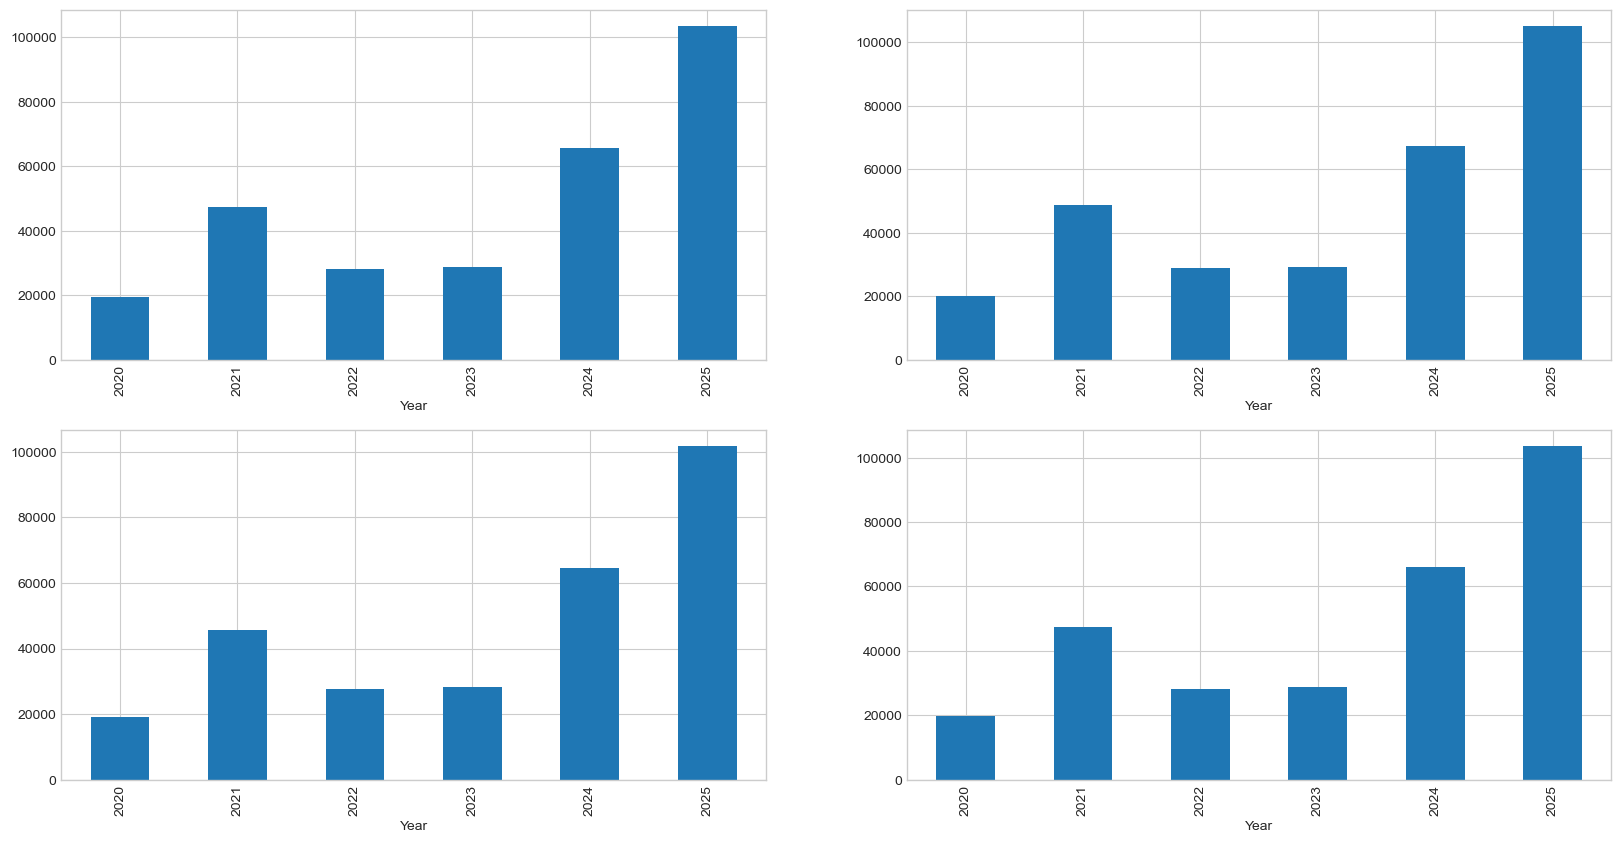

In [57]:
data_grouped = btc_dt.groupby('Year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [58]:
# Signal whether to buy or not 
btc_dt['Open-Close']  = btc_dt['Open'] - btc_dt['Close']
btc_dt['Low-High']  = btc_dt['Low'] - btc_dt['High']

# Create target column with 1% price sensitivity
btc_dt['Target'] = np.where(btc_dt['Close'].shift(-1) > btc_dt['Close'] * 1.01, 1, 0)

print(f"Price Sensitivity: 1% (0.01)")
print(f"Bullish signals (1): {btc_dt['Target'].sum()} ({btc_dt['Target'].sum()/len(btc_dt)*100:.2f}%)")
print(f"Bearish signals (0): {(btc_dt['Target']==0).sum()} ({(btc_dt['Target']==0).sum()/len(btc_dt)*100:.2f}%)")


Price Sensitivity: 1% (0.01)
Bullish signals (1): 593 (32.46%)
Bearish signals (0): 1234 (67.54%)


In [59]:
btc_dt.head()

,Close,Open,High,Low,Volume,Year,Month,Day,is_quarter_end,Open-Close,Low-High,Target
Date,,,,,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,2020,11,5,0,-1442.35,-1660.00,0
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,2020,11,6,0,8.11,-787.31,0
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,2020,11,7,0,765.86,-1469.24,1
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,2020,11,8,0,-648.81,-944.10,0
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,2020,11,9,0,140.64,-1039.76,0


In [60]:
# Technical Analysis Features

# Moving Averages
btc_dt['MA_7'] = btc_dt['Close'].rolling(window=7).mean()
btc_dt['MA_14'] = btc_dt['Close'].rolling(window=14).mean()
btc_dt['MA_21'] = btc_dt['Close'].rolling(window=21).mean()
btc_dt['MA_50'] = btc_dt['Close'].rolling(window=50).mean()
btc_dt['MA_200'] = btc_dt['Close'].rolling(window=200).mean()

# Exponential Moving Averages
btc_dt['EMA_12'] = btc_dt['Close'].ewm(span=12, adjust=False).mean()
btc_dt['EMA_26'] = btc_dt['Close'].ewm(span=26, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
btc_dt['MACD'] = btc_dt['EMA_12'] - btc_dt['EMA_26']
btc_dt['MACD_Signal'] = btc_dt['MACD'].ewm(span=9, adjust=False).mean()
btc_dt['MACD_Histogram'] = btc_dt['MACD'] - btc_dt['MACD_Signal']

# Relative Strength Index (RSI)
delta = btc_dt['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
btc_dt['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
btc_dt['BB_Middle'] = btc_dt['Close'].rolling(window=20).mean()
bb_std = btc_dt['Close'].rolling(window=20).std()
btc_dt['BB_Upper'] = btc_dt['BB_Middle'] + (bb_std * 2)
btc_dt['BB_Lower'] = btc_dt['BB_Middle'] - (bb_std * 2)
btc_dt['BB_Width'] = btc_dt['BB_Upper'] - btc_dt['BB_Lower']

# Price Rate of Change (ROC)
btc_dt['ROC'] = ((btc_dt['Close'] - btc_dt['Close'].shift(10)) / btc_dt['Close'].shift(10)) * 100

# Average True Range (ATR) - Volatility Indicator
high_low = btc_dt['High'] - btc_dt['Low']
high_close = np.abs(btc_dt['High'] - btc_dt['Close'].shift())
low_close = np.abs(btc_dt['Low'] - btc_dt['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
btc_dt['ATR'] = true_range.rolling(window=14).mean()

# Stochastic Oscillator
low_14 = btc_dt['Low'].rolling(window=14).min()
high_14 = btc_dt['High'].rolling(window=14).max()
btc_dt['Stochastic_%K'] = 100 * ((btc_dt['Close'] - low_14) / (high_14 - low_14))
btc_dt['Stochastic_%D'] = btc_dt['Stochastic_%K'].rolling(window=3).mean()

# On-Balance Volume (OBV)
btc_dt['OBV'] = (np.sign(btc_dt['Close'].diff()) * btc_dt['Volume']).fillna(0).cumsum()

# Volume Rate of Change
btc_dt['Volume_ROC'] = ((btc_dt['Volume'] - btc_dt['Volume'].shift(5)) / btc_dt['Volume'].shift(5)) * 100

# Price momentum
btc_dt['Momentum'] = btc_dt['Close'] - btc_dt['Close'].shift(4)

# Percentage change features
btc_dt['Daily_Return'] = btc_dt['Close'].pct_change() * 100
btc_dt['Volatility_10'] = btc_dt['Daily_Return'].rolling(window=10).std()
btc_dt['Volatility_30'] = btc_dt['Daily_Return'].rolling(window=30).std()

_logs.info(f"Technical analysis features created. Dataset now has {btc_dt.shape[1]} features.")

2025-11-09 18:15:08,420, 4133966.py, 63, INFO, Technical analysis features created. Dataset now has 37 features.


In [63]:
btc_dt.info()
btc_dt.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-11-05 to 2025-11-05
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           1827 non-null   float64
 1   Open            1827 non-null   float64
 2   High            1827 non-null   float64
 3   Low             1827 non-null   float64
 4   Volume          1827 non-null   int64  
 5   Year            1827 non-null   int32  
 6   Month           1827 non-null   int32  
 7   Day             1827 non-null   int32  
 8   is_quarter_end  1827 non-null   int64  
 9   Open-Close      1827 non-null   float64
 10  Low-High        1827 non-null   float64
 11  Target          1827 non-null   int64  
 12  MA_7            1821 non-null   float64
 13  MA_14           1814 non-null   float64
 14  MA_21           1807 non-null   float64
 15  MA_50           1778 non-null   float64
 16  MA_200          1628 non-null   float64
 17  EMA_12         

,Close,Open,High,Low,Volume,Year,Month,Day,is_quarter_end,Open-Close,...,ROC,ATR,Stochastic_%K,Stochastic_%D,OBV,Volume_ROC,Momentum,Daily_Return,Volatility_10,Volatility_30
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,2020,11,5,0,-1442.35,...,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,2020,11,6,0,8.11,...,NaN,NaN,NaN,NaN,-3.983784e+10,NaN,NaN,-0.052921,NaN,NaN
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,2020,11,7,0,765.86,...,NaN,NaN,NaN,NaN,-7.486280e+10,NaN,NaN,-4.909375,NaN,NaN
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,2020,11,8,0,-648.81,...,NaN,NaN,NaN,NaN,-4.823072e+10,NaN,NaN,4.373777,NaN,NaN
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,2020,11,9,0,140.64,...,NaN,NaN,NaN,NaN,-8.237984e+10,NaN,-265.96,-0.908422,NaN,NaN


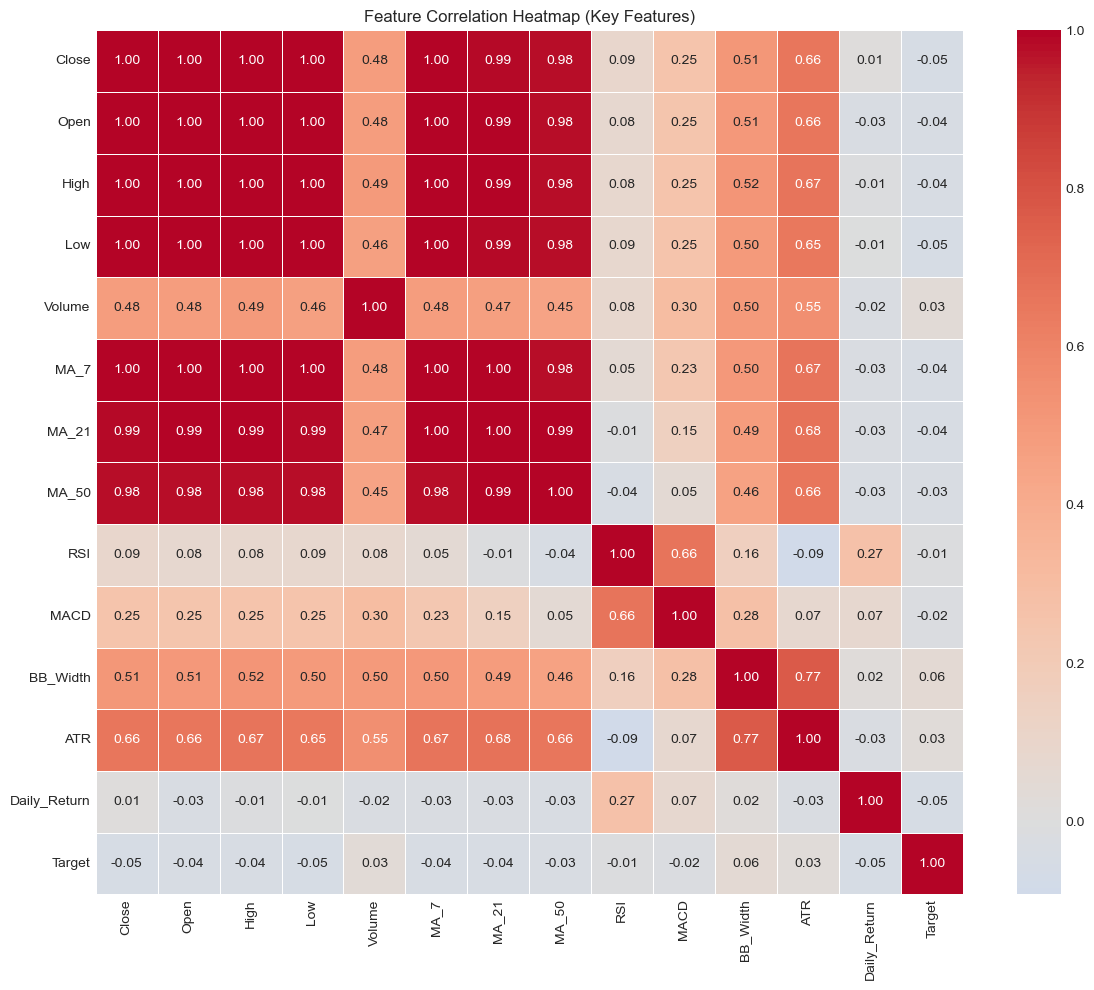

In [62]:
# Correlation Heatmap - simplified version
# Selecting most important features to reduce visual clutter
important_features = ['Close', 'Open', 'High', 'Low', 'Volume', 
                      'MA_7', 'MA_21', 'MA_50', 'RSI', 'MACD', 
                      'BB_Width', 'ATR', 'Daily_Return', 'Target']

plt.figure(figsize=(12, 10))
sb.heatmap(btc_dt[important_features].corr(), annot=True, cbar=True, fmt='.2f', 
           cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Correlation Heatmap (Key Features)')
plt.tight_layout()
plt.show()


# Sentiment Data + BTC Data

In [65]:
print("=== BTC Data Info ===")
btc_dt.info()
print("\n=== Aggregated Sentiment Info ===")
df_aggregated.info()

=== BTC Data Info ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-11-05 to 2025-11-05
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           1827 non-null   float64
 1   Open            1827 non-null   float64
 2   High            1827 non-null   float64
 3   Low             1827 non-null   float64
 4   Volume          1827 non-null   int64  
 5   Year            1827 non-null   int32  
 6   Month           1827 non-null   int32  
 7   Day             1827 non-null   int32  
 8   is_quarter_end  1827 non-null   int64  
 9   Open-Close      1827 non-null   float64
 10  Low-High        1827 non-null   float64
 11  Target          1827 non-null   int64  
 12  MA_7            1821 non-null   float64
 13  MA_14           1814 non-null   float64
 14  MA_21           1807 non-null   float64
 15  MA_50           1778 non-null   float64
 16  MA_200          1628 non-null   float6

In [ ]:
#re assigning names
btc_df = btc_dt
sen_df = df_aggregated

In [70]:
# standardizing names
sen_df = sen_df.rename(columns={
    'year':  'Year',
    'month': 'Month',
    'day':   'Day'
})


In [ ]:
#merging!
merged_df = pd.merge(
    btc_df,
    sen_df[['Year','Month','Day','total_score']],
    how='left',
    on=['Year','Month','Day']
)
merged_df.head()
merged_df.info()

#USE THIS MERGED DATAFRAME TO FEED THE REST OF THE MODEL JULIAN!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           1827 non-null   float64
 1   Open            1827 non-null   float64
 2   High            1827 non-null   float64
 3   Low             1827 non-null   float64
 4   Volume          1827 non-null   int64  
 5   Year            1827 non-null   int32  
 6   Month           1827 non-null   int32  
 7   Day             1827 non-null   int32  
 8   is_quarter_end  1827 non-null   int64  
 9   Open-Close      1827 non-null   float64
 10  Low-High        1827 non-null   float64
 11  Target          1827 non-null   int64  
 12  MA_7            1821 non-null   float64
 13  MA_14           1814 non-null   float64
 14  MA_21           1807 non-null   float64
 15  MA_50           1778 non-null   float64
 16  MA_200          1628 non-null   float64
 17  EMA_12          1827 non-null   f

# Model VADER Sentiment + Price

In [ ]:
#in progress

# Model Development


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import warnings

warnings.filterwarnings('ignore')

# Prepare data - drop rows with NaN values and select features
ml_data = btc_dt.dropna().copy()

# Select features for modeling (excluding target and date-related features)
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'Open-Close', 'Low-High',
                'MA_7', 'MA_14', 'MA_21', 'MA_50', 'MA_200',
                'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
                'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width',
                'ROC', 'ATR', 'Stochastic_%K', 'Stochastic_%D',
                'OBV', 'Volume_ROC', 'Momentum', 'Daily_Return',
                'Volatility_10', 'Volatility_30']

X = ml_data[feature_cols]
y = ml_data['Target']

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

_logs.info(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# 1. Logistic Regression
_logs.info("Training Logistic Regression model...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, lr_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

# 2. Random Forest
_logs.info("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("RANDOM FOREST RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# 3. XGBoost
_logs.info("Training XGBoost model...")
xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("XGBOOST RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, xgb_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))


_logs.info("Model training completed successfully.")


2025-11-06 19:35:16,038, 2794898342.py, 35, INFO, Training set size: 1302, Test set size: 326
2025-11-06 19:35:16,038, 2794898342.py, 38, INFO, Training Logistic Regression model...
2025-11-06 19:35:16,085, 2794898342.py, 53, INFO, Training Random Forest model...


LOGISTIC REGRESSION RESULTS
Accuracy: 0.6963
ROC-AUC Score: 0.5764

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       238
           1       0.37      0.18      0.24        88

    accuracy                           0.70       326
   macro avg       0.56      0.53      0.53       326
weighted avg       0.64      0.70      0.66       326



2025-11-06 19:35:16,428, 2794898342.py, 68, INFO, Training XGBoost model...
2025-11-06 19:35:16,599, 2794898342.py, 83, INFO, Model training completed successfully.


RANDOM FOREST RESULTS
Accuracy: 0.5276
ROC-AUC Score: 0.5040

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.53      0.62       238
           1       0.29      0.52      0.37        88

    accuracy                           0.53       326
   macro avg       0.52      0.53      0.50       326
weighted avg       0.63      0.53      0.55       326

XGBOOST RESULTS
Accuracy: 0.7301
ROC-AUC Score: 0.5787

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       238
           1       0.50      0.15      0.23        88

    accuracy                           0.73       326
   macro avg       0.62      0.55      0.53       326
weighted avg       0.68      0.73      0.67       326



In [23]:
def prepare_data_for_modeling(btc_dt, feature_cols, test_size=0.2, random_state=42):
    """Prepare data by dropping NaN values and splitting into train/test sets."""
    ml_data = btc_dt.dropna().copy()
    X = ml_data[feature_cols]
    y = ml_data['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    
    _logs.info(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
    return X_train, X_test, y_train, y_test, ml_data

def scale_features(X_train, X_test):
    """Scale features using StandardScaler."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

def train_logistic_regression(X_train_scaled, y_train, random_state=42):
    """Train Logistic Regression model."""
    _logs.info("Training Logistic Regression model...")
    lr_model = LogisticRegression(random_state=random_state, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train)
    return lr_model

def train_random_forest(X_train_scaled, y_train, random_state=42):
    """Train Random Forest model."""
    _logs.info("Training Random Forest model...")
    rf_model = RandomForestClassifier(
        n_estimators=100, random_state=random_state, 
        max_depth=10, min_samples_split=5
    )
    rf_model.fit(X_train_scaled, y_train)
    return rf_model

def train_xgboost(X_train_scaled, y_train, random_state=42):
    """Train XGBoost model."""
    _logs.info("Training XGBoost model...")
    xgb_model = XGBClassifier(
        n_estimators=100, random_state=random_state, 
        max_depth=5, learning_rate=0.1, eval_metric='logloss'
    )
    xgb_model.fit(X_train_scaled, y_train)
    return xgb_model

def evaluate_model(model, X_test_scaled, y_test, model_name):
    """Evaluate model and print results."""
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    print("=" * 60)
    print(f"{model_name} RESULTS")
    print("=" * 60)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return y_pred, y_prob


# Feature columns for modeling
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'Open-Close', 'Low-High',
                'MA_7', 'MA_14', 'MA_21', 'MA_50', 'MA_200',
                'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
                'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width',
                'ROC', 'ATR', 'Stochastic_%K', 'Stochastic_%D',
                'OBV', 'Volume_ROC', 'Momentum', 'Daily_Return',
                'Volatility_10', 'Volatility_30']

# Prepare and scale data
X_train, X_test, y_train, y_test, ml_data = prepare_data_for_modeling(btc_dt, feature_cols)
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)

# Train models
lr_model = train_logistic_regression(X_train_scaled, y_train)
rf_model = train_random_forest(X_train_scaled, y_train)
xgb_model = train_xgboost(X_train_scaled, y_train)

# Evaluate models
lr_pred, lr_prob = evaluate_model(lr_model, X_test_scaled, y_test, "LOGISTIC REGRESSION")
rf_pred, rf_prob = evaluate_model(rf_model, X_test_scaled, y_test, "RANDOM FOREST")
xgb_pred, xgb_prob = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBOOST")

_logs.info("Model training completed successfully.")


2025-11-06 19:35:41,804, 1151701797.py, 11, INFO, Training set size: 1302, Test set size: 326
2025-11-06 19:35:41,811, 1151701797.py, 23, INFO, Training Logistic Regression model...
2025-11-06 19:35:41,821, 1151701797.py, 30, INFO, Training Random Forest model...
2025-11-06 19:35:42,191, 1151701797.py, 40, INFO, Training XGBoost model...
2025-11-06 19:35:42,393, 1151701797.py, 88, INFO, Model training completed successfully.


LOGISTIC REGRESSION RESULTS
Accuracy: 0.6963
ROC-AUC Score: 0.5764

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       238
           1       0.37      0.18      0.24        88

    accuracy                           0.70       326
   macro avg       0.56      0.53      0.53       326
weighted avg       0.64      0.70      0.66       326

RANDOM FOREST RESULTS
Accuracy: 0.5276
ROC-AUC Score: 0.5040

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.53      0.62       238
           1       0.29      0.52      0.37        88

    accuracy                           0.53       326
   macro avg       0.52      0.53      0.50       326
weighted avg       0.63      0.53      0.55       326

XGBOOST RESULTS
Accuracy: 0.7301
ROC-AUC Score: 0.5787

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95   

## LSTM

An LSTM learns how Bitcoin behaves over time by looking at patterns in the past, remembering the important parts, and using that memory to estimate where price is heading next.


- Goal/label: Binary target = 1 if tomorrow’s close > today by >1%, else 0.
- Inputs: 31 technical features per day (price/volume + indicators).
- Temporal framing: Predict the next day’s label using a 10-day lookback window of features.


Note: you may need to restart the kernel to use updated packages.


2025-11-06 19:36:02,457, 2100689613.py, 39, INFO, LSTM Training sequences shape: (1292, 10, 32)
2025-11-06 19:36:02,458, 2100689613.py, 40, INFO, LSTM Test sequences shape: (316, 10, 32)
2025-11-06 19:36:02,458, 2100689613.py, 44, INFO, LSTM model architecture:


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            24832     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 37,793
Trainable params: 37,793
Non-traina

2025-11-06 19:36:02,686, 2100689613.py, 79, INFO, Training LSTM model:


Epoch 1/50


2025-11-06 19:36:02.717341: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 2s 18ms/step - loss: 0.6550 - accuracy: 0.6370 - val_loss: 0.7051 - val_accuracy: 0.4247
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6415 - accuracy: 0.6786 - val_loss: 0.6432 - val_accuracy: 0.6718
Epoch 3/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6260 - accuracy: 0.6776 - val_loss: 0.6713 - val_accuracy: 0.6216
Epoch 4/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6223 - accuracy: 0.6796 - val_loss: 0.6425 - val_accuracy: 0.6680
Epoch 5/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6189 - accuracy: 0.6796 - val_loss: 0.6839 - val_accuracy: 0.5598
Epoch 6/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6180 - accuracy: 0.6815 - val_loss: 0.6370 - val_accuracy: 0.6718
Epoch 7/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6127 - accuracy: 0.6815 - val_loss: 0.7056 - val_accuracy: 0.4440
Epoch 8/50
33/33 [============

2025-11-06 19:36:08,429, 2100689613.py, 103, INFO, LSTM model training completed successfully.


LSTM RESULTS
Accuracy: 0.7278
ROC-AUC Score: 0.5661

Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       230
           1       0.00      0.00      0.00        86

    accuracy                           0.73       316
   macro avg       0.36      0.50      0.42       316
weighted avg       0.53      0.73      0.61       316



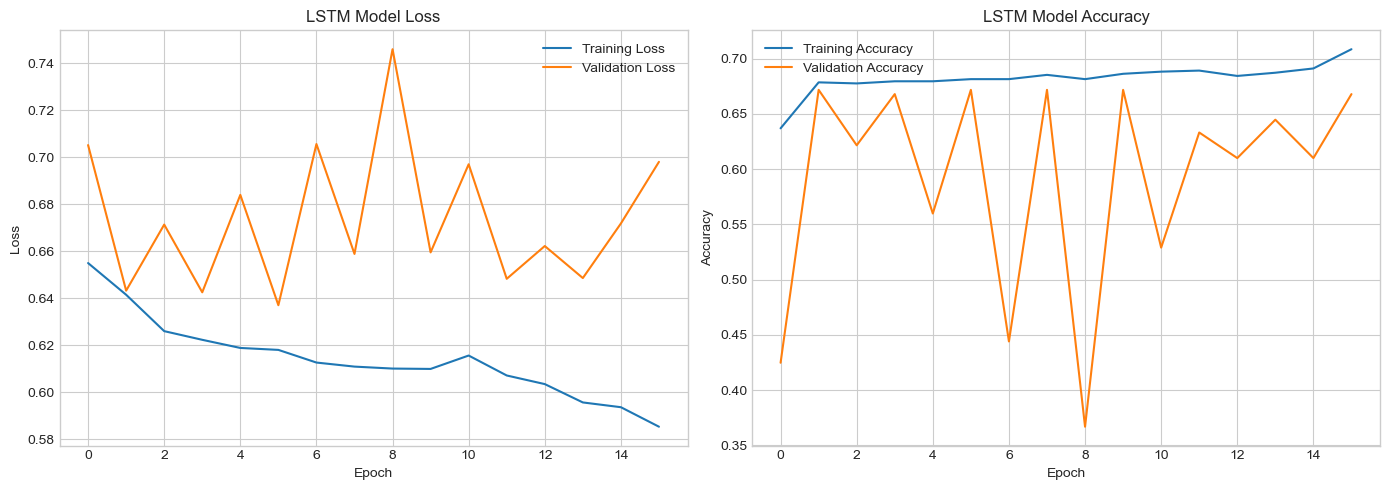

In [24]:
%pip install tensorflow
# LSTM Model for Time Series Classification

# Features (31 technical indicators):
# Price data: Open, High, Low, Close, Volume
# Engineered: Open-Close, Low-High
# Moving Averages: MA_7, MA_14, MA_21, MA_50, MA_200, EMA_12, EMA_26
# MACD indicators: MACD, MACD_Signal, MACD_Histogram
# RSI, Bollinger Bands (BB_Middle, BB_Upper, BB_Lower, BB_Width)
# ROC, ATR, Stochastic_%K, Stochastic_%D
# Volume indicators: OBV, Volume_ROC
# Momentum, Daily_Return, Volatility_10, Volatility_30
#
# Target: Binary classification (0 or 1) predicting if tomorrow's close price will be >1% higher than today
# Sequence Structure: Each training sample looks at 10 consecutive time periods to predict the next period's target

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Prepare data for LSTM (needs 3D shape: samples, timesteps, features)
def create_sequences(X, y, timesteps=10):
    """Create sequences for LSTM input."""
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
timesteps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, timesteps)

_logs.info(f"LSTM Training sequences shape: {X_train_seq.shape}")
_logs.info(f"LSTM Test sequences shape: {X_test_seq.shape}")

# Build LSTM model
# Model 1: 2×LSTM (64 → 32) + Dropout + Dense(16) → Sigmoid.
_logs.info("LSTM model architecture:")
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(timesteps, X_train_scaled.shape[1])),   # Input layer
    Dropout(0.2),                                                                                           # Dropout layer regularization to prevent overfitting
    LSTM(32, activation='tanh'),                                                                            # Second LSTM layer compressing into a single 32-dimensional vector
    Dropout(0.2),                                                                                           # Dropout layer
    Dense(16, activation='tanh'),                                                                           # Non-linear dense layer for feature extraction
    Dense(1, activation='sigmoid')                                                                          # Output layer for binary classification
])

# Model 2: 2×LSTM (64 → 32) + Dropout + Dense(16) → Sigmoid.
# _logs.info("LSTM model architecture:")
# lstm_model = Sequential([
#     LSTM(64, activation='relu', return_sequences=True, input_shape=(timesteps, X_train_scaled.shape[1])),   # Input layer
#     Dropout(0.2),                                                                                           # Dropout layer regularization to prevent overfitting
#     LSTM(32, activation='relu'),                                                                            # Second LSTM layer compressing into a single 32-dimensional vector
#     Dropout(0.2),                                                                                           # Dropout layer
#     Dense(16, activation='relu'),                                                                           # Non-linear dense layer for feature extraction 
#     Dense(1, activation='sigmoid')                                                                          # Output layer for binary classification
# ])

# Compile model 
lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
lstm_model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train LSTM model with no shuffle
_logs.info("Training LSTM model:")
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

# Make predictions
lstm_pred_prob = lstm_model.predict(X_test_seq)
lstm_pred = (lstm_pred_prob > 0.5).astype(int).flatten()

# Evaluate LSTM model
print("=" * 60)
print("LSTM RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test_seq, lstm_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test_seq, lstm_pred_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_seq, lstm_pred))

_logs.info("LSTM model training completed successfully.")

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### LSTM Tuning

** Class Imbalance **
- Target condition (up tomorrow > 1%) is relatively rare.
- Predicting 0 always

Remedy:
- Adding class weights during training


Epoch 1/50
33/33 [==============================] - 1s 7ms/step - loss: 0.7085 - accuracy: 0.6534 - val_loss: 0.7760 - val_accuracy: 0.3282
Epoch 2/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.4763 - val_loss: 0.7261 - val_accuracy: 0.3822
Epoch 3/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6804 - accuracy: 0.6205 - val_loss: 0.7690 - val_accuracy: 0.3282
Epoch 4/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6772 - accuracy: 0.5382 - val_loss: 0.7487 - val_accuracy: 0.3629
Epoch 5/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6689 - accuracy: 0.6157 - val_loss: 0.7846 - val_accuracy: 0.3629
Epoch 6/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6642 - accuracy: 0.6012 - val_loss: 0.8205 - val_accuracy: 0.3552
Epoch 7/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6597 - accuracy: 0.6196 - val_loss: 0.7149 - val_accuracy: 0.4826
Epoch 8/50
33/33 [==

2025-11-06 19:36:39,330, 2919437839.py, 31, INFO, LSTM model training completed successfully.


LSTM RESULTS
Accuracy: 0.7278
ROC-AUC Score: 0.5733

Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       230
           1       0.00      0.00      0.00        86

    accuracy                           0.73       316
   macro avg       0.36      0.50      0.42       316
weighted avg       0.53      0.73      0.61       316



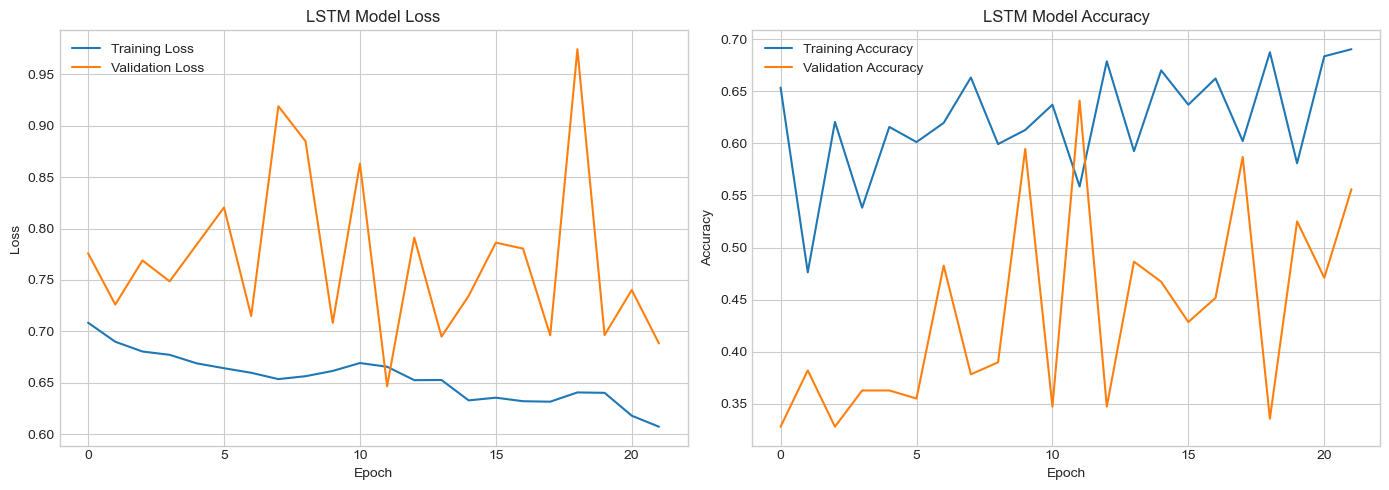

2025-11-06 19:36:39,459, 2919437839.py, 57, INFO, LSTM model training with class weights completed successfully.


In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

cw = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_seq)
class_weight = {0: cw[0], 1: cw[1]}

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

# Make predictions
lstm_pred_prob = lstm_model.predict(X_test_seq)
lstm_pred = (lstm_pred_prob > 0.5).astype(int).flatten()

# Evaluate LSTM model
print("=" * 60)
print("LSTM RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test_seq, lstm_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test_seq, lstm_pred_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_seq, lstm_pred))

_logs.info("LSTM model training completed successfully.")

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

_logs.info("LSTM model training with class weights completed successfully.")